# MNISTでDCGANを試す

## moduleのimport

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

## データの前処理に使うtransform

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

## torchvisionからデータをダウンロードし、transformで前処理

In [3]:
#訓練データをtorchvisionでダウンロード
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

## Dataloaderの定義

In [4]:
import numpy as np
batch_size = 128

#訓練データ用データローダー
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

## ネットワーク：Generatorの定義

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator,self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(z_dim,1024), #入力は62次元の乱数
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1), #チャネル数を128⇒64に変える。
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,1, kernel_size=4, stride=2, padding=1), #チャネル数を28×28に変更
            nn.Sigmoid(),
        )

        self.init_weights()
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                #nn.init.kaiming_uniform_(module.weight)
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
        
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1,128,7,7)
        x = self.deconv(x)
        return x


In [7]:
print(Generator(62))

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)


## ネットワーク：Discriminatorの定義

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), #入力は1チャネル(白黒だから), フィルターの数64, フィルターのサイズ4*4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        self.init_weights()
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                #nn.init.kaiming_uniform_(module.weight)
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
                
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [9]:
print(Discriminator())

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


## 1エポックごとに計算する関数を定義

In [10]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_func(D_model, G_model, batch_size, z_dim, criterion, D_optimizer, G_optimizer, D_scheduler, G_scheduler, data_loader, device):
    #訓練モード
    D_model.train()
    G_model.train()
    
    #本物のラベルは1
    y_real = torch.ones((batch_size, 1)).to(device)

    #偽物のラベルは0
    y_fake = torch.zeros((batch_size, 1)).to(device)
    
    #lossの初期化
    D_running_loss = 0
    G_running_loss = 0
    
    #バッチごとの計算
    for batch_idx, (data, _) in enumerate(data_loader):
        #バッチサイズに満たない場合は無視
        if data.size()[0] != batch_size:
            break
        
        #ノイズ作成
        z = torch.rand((batch_size, z_dim)) #[0,1)の一様分布に従った乱数を生成
        
        real_img, z = data.to(device), z.to(device)
        
        #Discriminatorの更新
        D_optimizer.zero_grad()
        
        #Discriminatorに本物画像を入れて順伝播⇒Loss計算
        D_real = D_model(real_img)
        D_real_loss = criterion(D_real, y_real)
        
        #DiscriminatorにGeneratorにノイズを入れて作った画像を入れて順伝播⇒Loss計算
        fake_img = G_model(z)
        D_fake = D_model(fake_img.detach()) #fake_imagesで計算したLossをGeneratorに逆伝播させないように止める
        D_fake_loss = criterion(D_fake, y_fake)
        
        #2つのLossの和を最小化
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        
        #Generatorの更新
        G_optimizer.zero_grad()
        
        #Generatorにノイズを入れて作った画像をDiscriminatorに入れて順伝播⇒見破られた分がLossになる
        fake_img = G_model(z)
        D_fake = D_model(fake_img)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        #schedulerの更新
        if D_scheduler != 'None':
            D_scheduler.step()
        if G_scheduler != 'None':
            G_scheduler.step()
        
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

## Generatorが作った画像を表示する関数

In [17]:
import os
from IPython.display import Image
from torchvision.utils import save_image
%matplotlib inline

def Generate_img(epoch, G_model, device, noise, log_dir = 'logs_DCGAN'):
    G_model.eval()
    
    with torch.no_grad():

        #Generatorでサンプル生成
        samples = G_model(noise).data.cpu()
        save_image(samples, os.path.join(log_dir, 'epoch_%05d.png' % (epoch)))
        img = Image('logs_DCGAN/epoch_%05d.png' % (epoch))
        display(img)

## モデルをエポックごとに計算し、結果を表示

In [18]:
import time
import adabound
import random
import numpy as np
import torch.optim as optim

#再現性確保のためseed値固定
SEED = 1111
random.seed(SEED)
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#optimizerを決める関数
def return_optim(optim, model):
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    elif optim == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif optim == 'Adabound':
        optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
        
    return optimizer

#schedulerを決める関数
def return_scheduler(scheduler, model):
    if scheduler == 'None':
        shceduler = 'None'
    elif scheduler == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, int(num_epochs/2), gamma=0.5)
    elif scheduler == 'MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/4),int(num_epochs*2/4),int(num_epochs*3/4)], gamma=0.1, last_epoch=-1)
    elif scheduler == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
    elif scheduler == 'CosineAnnelingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(num_epochs/4), eta_min=0, last_epoch=-1)
    elif scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, \
                                                               threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    elif scheduler == 'CyclicLR':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=3, step_size_up=2000, step_size_down=None, \
                                                      mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True,\
                                                      base_momentum=0.8, max_momentum=0.9, last_epoch=-1)
    
    return scheduler
    

def model_run(num_epochs, batch_size = batch_size, D_optim = 'SGD', G_optim = 'SGD', D_scheduler = 'None', G_scheduler = 'None',trainloader = trainloader, device = device):
    
    #ハイパーパラメータ
    z_dim = 62
    #Generatorの結果を生成するのに必要な乱数 (⇒毎回入れる乱数を固定にしておくことになる)
    noise = torch.rand((64, z_dim)).to(device)
    
    #モデル定義
    #min_valid_loss = float('inf')
    D_model = Discriminator().to(device)
    G_model = Generator(z_dim).to(device)
    
    #lossの定義(引数はtrain_funcの中で指定)
    criterion = nn.BCELoss().to(device)
    
    #optimizerの定義
    D_optimizer = return_optim(D_optim, D_model)
    G_optimizer = return_optim(G_optim, G_model)
    
    #scheduler（学習率の調整法）の定義
    D_scheduler = return_scheduler(D_scheduler, D_optim)
    G_scheduler = return_scheduler(G_scheduler, G_optim)
    
    D_loss_list = []
    G_loss_list = []
    
    all_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()
        
        D_loss, G_loss = train_func(D_model, G_model, batch_size, z_dim, criterion, D_optimizer, G_optimizer, D_scheduler, G_scheduler, trainloader, device)
        
        D_loss_list.append(D_loss)
        G_loss_list.append(G_loss)
        
        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60
        
        #エポックごとに結果を表示
        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {D_loss:.4f}(Discriminator)')
        print(f'\tLoss: {G_loss:.4f}(Generator)')
        
        if (epoch + 1) % 1 == 0:
            Generate_img(epoch, G_model, device, noise)
            
    return D_loss_list, G_loss_list

Epoch: 1  | 所要時間 0 分 8 秒
	Loss: 0.8520(Discriminator)
	Loss: 1.3039(Generator)


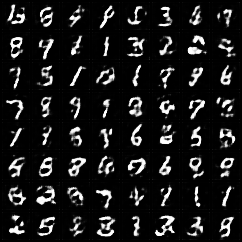

Epoch: 2  | 所要時間 0 分 8 秒
	Loss: 1.0269(Discriminator)
	Loss: 1.1455(Generator)


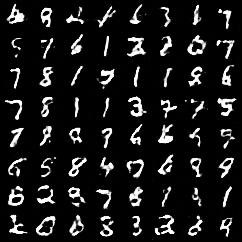

Epoch: 3  | 所要時間 0 分 8 秒
	Loss: 1.0557(Discriminator)
	Loss: 1.1205(Generator)


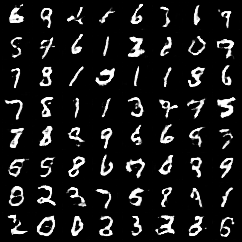

Epoch: 4  | 所要時間 0 分 8 秒
	Loss: 1.0527(Discriminator)
	Loss: 1.1309(Generator)


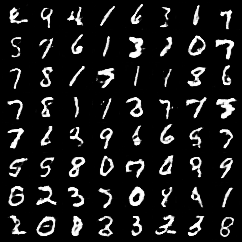

Epoch: 5  | 所要時間 0 分 8 秒
	Loss: 1.0374(Discriminator)
	Loss: 1.1611(Generator)


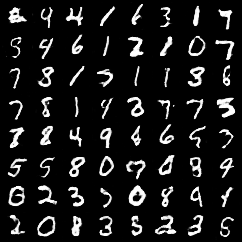

Epoch: 6  | 所要時間 0 分 8 秒
	Loss: 1.0138(Discriminator)
	Loss: 1.1954(Generator)


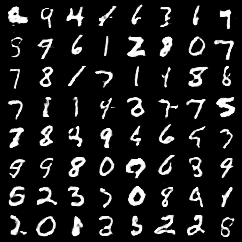

Epoch: 7  | 所要時間 0 分 8 秒
	Loss: 0.9903(Discriminator)
	Loss: 1.2360(Generator)


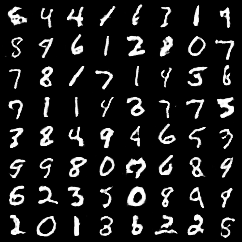

Epoch: 8  | 所要時間 0 分 8 秒
	Loss: 0.9585(Discriminator)
	Loss: 1.2823(Generator)


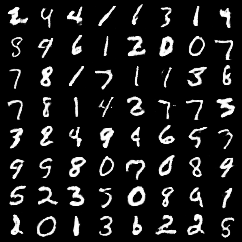

Epoch: 9  | 所要時間 0 分 8 秒
	Loss: 0.9208(Discriminator)
	Loss: 1.3432(Generator)


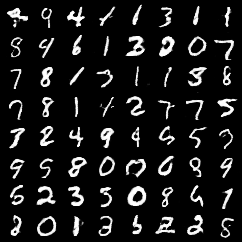

Epoch: 10  | 所要時間 0 分 8 秒
	Loss: 0.8910(Discriminator)
	Loss: 1.3963(Generator)


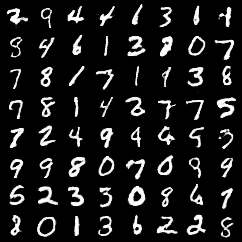

Epoch: 11  | 所要時間 0 分 8 秒
	Loss: 0.8652(Discriminator)
	Loss: 1.4496(Generator)


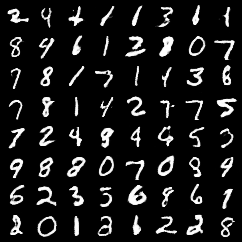

Epoch: 12  | 所要時間 0 分 8 秒
	Loss: 0.8338(Discriminator)
	Loss: 1.5060(Generator)


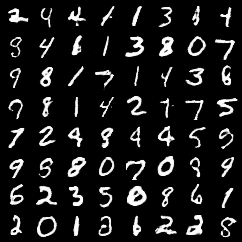

Epoch: 13  | 所要時間 0 分 8 秒
	Loss: 0.8105(Discriminator)
	Loss: 1.5610(Generator)


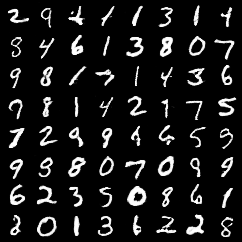

Epoch: 14  | 所要時間 0 分 8 秒
	Loss: 0.7861(Discriminator)
	Loss: 1.6019(Generator)


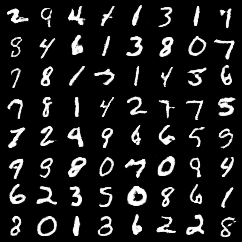

Epoch: 15  | 所要時間 0 分 8 秒
	Loss: 0.7674(Discriminator)
	Loss: 1.6575(Generator)


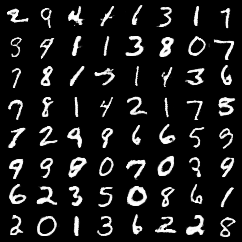

Epoch: 16  | 所要時間 0 分 8 秒
	Loss: 0.7402(Discriminator)
	Loss: 1.7153(Generator)


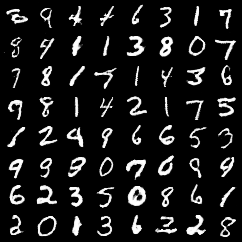

Epoch: 17  | 所要時間 0 分 8 秒
	Loss: 0.7187(Discriminator)
	Loss: 1.7598(Generator)


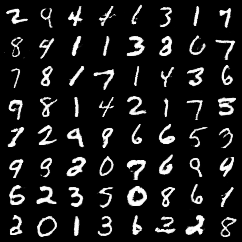

Epoch: 18  | 所要時間 0 分 8 秒
	Loss: 0.7066(Discriminator)
	Loss: 1.8063(Generator)


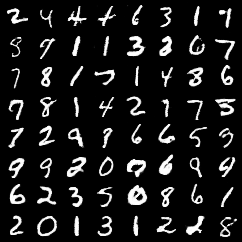

Epoch: 19  | 所要時間 0 分 8 秒
	Loss: 0.6805(Discriminator)
	Loss: 1.8567(Generator)


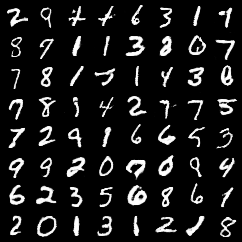

Epoch: 20  | 所要時間 0 分 8 秒
	Loss: 0.6581(Discriminator)
	Loss: 1.9026(Generator)


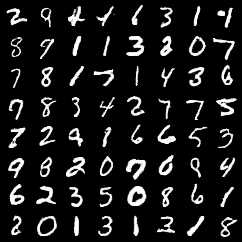

Epoch: 21  | 所要時間 0 分 8 秒
	Loss: 0.6582(Discriminator)
	Loss: 1.9576(Generator)


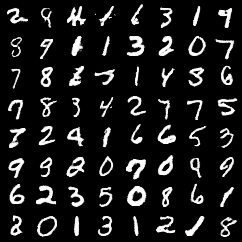

Epoch: 22  | 所要時間 0 分 8 秒
	Loss: 0.6247(Discriminator)
	Loss: 2.0014(Generator)


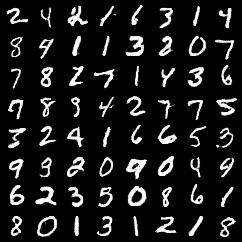

Epoch: 23  | 所要時間 0 分 8 秒
	Loss: 0.6211(Discriminator)
	Loss: 2.0312(Generator)


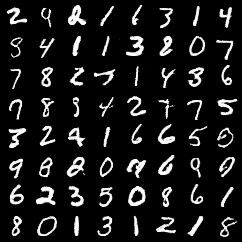

Epoch: 24  | 所要時間 0 分 8 秒
	Loss: 0.5998(Discriminator)
	Loss: 2.0901(Generator)


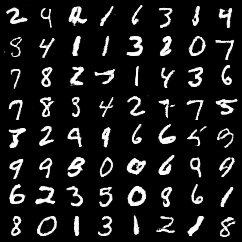

Epoch: 25  | 所要時間 0 分 8 秒
	Loss: 0.6039(Discriminator)
	Loss: 2.1106(Generator)


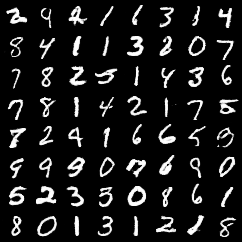

Epoch: 26  | 所要時間 0 分 8 秒
	Loss: 0.5823(Discriminator)
	Loss: 2.1613(Generator)


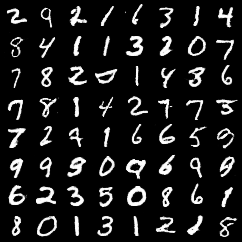

Epoch: 27  | 所要時間 0 分 8 秒
	Loss: 0.5659(Discriminator)
	Loss: 2.2164(Generator)


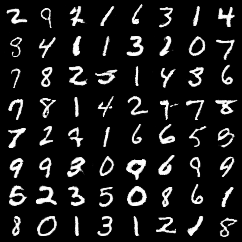

Epoch: 28  | 所要時間 0 分 8 秒
	Loss: 0.5680(Discriminator)
	Loss: 2.2314(Generator)


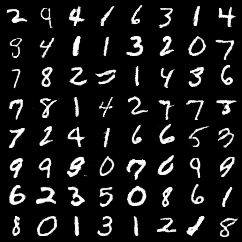

Epoch: 29  | 所要時間 0 分 8 秒
	Loss: 0.5484(Discriminator)
	Loss: 2.2781(Generator)


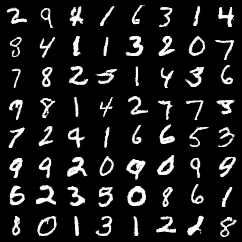

Epoch: 30  | 所要時間 0 分 8 秒
	Loss: 0.5353(Discriminator)
	Loss: 2.3208(Generator)


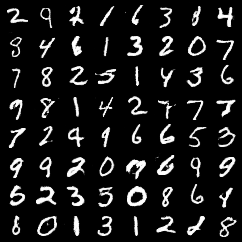

Epoch: 31  | 所要時間 0 分 8 秒
	Loss: 0.5438(Discriminator)
	Loss: 2.3484(Generator)


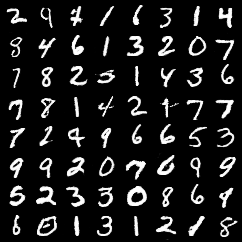

Epoch: 32  | 所要時間 0 分 8 秒
	Loss: 0.5261(Discriminator)
	Loss: 2.3894(Generator)


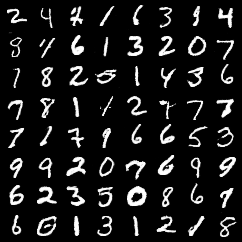

Epoch: 33  | 所要時間 0 分 8 秒
	Loss: 0.5301(Discriminator)
	Loss: 2.3917(Generator)


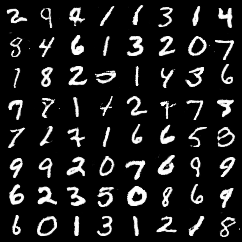

Epoch: 34  | 所要時間 0 分 8 秒
	Loss: 0.5009(Discriminator)
	Loss: 2.4508(Generator)


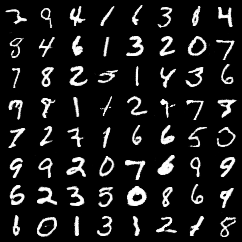

Epoch: 35  | 所要時間 0 分 8 秒
	Loss: 0.5098(Discriminator)
	Loss: 2.4795(Generator)


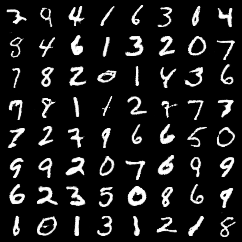

Epoch: 36  | 所要時間 0 分 8 秒
	Loss: 0.4938(Discriminator)
	Loss: 2.5019(Generator)


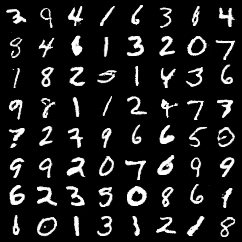

Epoch: 37  | 所要時間 0 分 8 秒
	Loss: 0.4911(Discriminator)
	Loss: 2.5487(Generator)


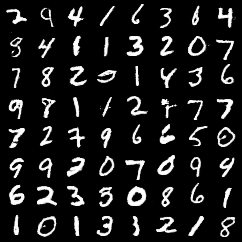

Epoch: 38  | 所要時間 0 分 8 秒
	Loss: 0.4802(Discriminator)
	Loss: 2.5832(Generator)


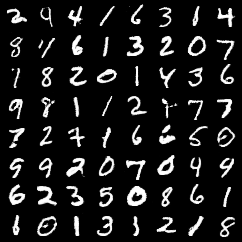

Epoch: 39  | 所要時間 0 分 8 秒
	Loss: 0.4727(Discriminator)
	Loss: 2.6007(Generator)


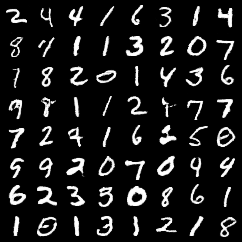

Epoch: 40  | 所要時間 0 分 8 秒
	Loss: 0.4714(Discriminator)
	Loss: 2.6377(Generator)


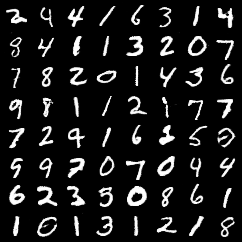

Epoch: 41  | 所要時間 0 分 8 秒
	Loss: 0.4620(Discriminator)
	Loss: 2.6504(Generator)


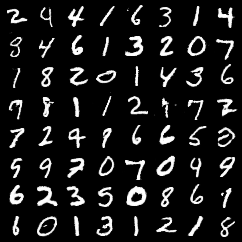

Epoch: 42  | 所要時間 0 分 8 秒
	Loss: 0.4539(Discriminator)
	Loss: 2.6988(Generator)


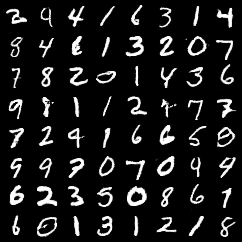

Epoch: 43  | 所要時間 0 分 8 秒
	Loss: 0.4551(Discriminator)
	Loss: 2.7255(Generator)


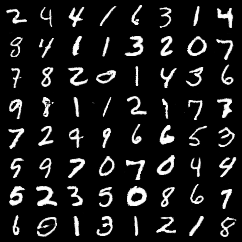

Epoch: 44  | 所要時間 0 分 8 秒
	Loss: 0.4398(Discriminator)
	Loss: 2.7451(Generator)


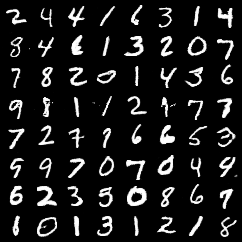

Epoch: 45  | 所要時間 0 分 8 秒
	Loss: 0.4597(Discriminator)
	Loss: 2.7567(Generator)


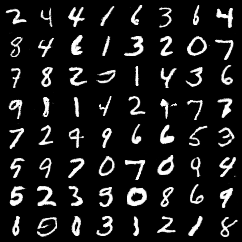

Epoch: 46  | 所要時間 0 分 8 秒
	Loss: 0.4265(Discriminator)
	Loss: 2.8042(Generator)


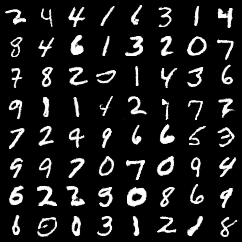

Epoch: 47  | 所要時間 0 分 8 秒
	Loss: 0.4522(Discriminator)
	Loss: 2.8212(Generator)


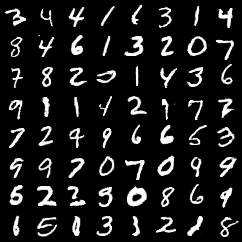

Epoch: 48  | 所要時間 0 分 8 秒
	Loss: 0.4190(Discriminator)
	Loss: 2.8349(Generator)


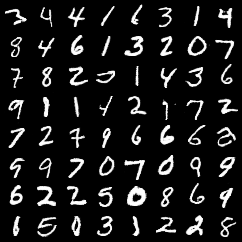

Epoch: 49  | 所要時間 0 分 8 秒
	Loss: 0.4116(Discriminator)
	Loss: 2.8905(Generator)


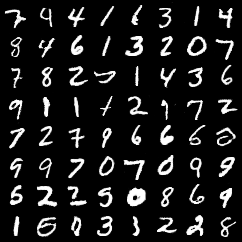

Epoch: 50  | 所要時間 0 分 8 秒
	Loss: 0.4132(Discriminator)
	Loss: 2.9112(Generator)


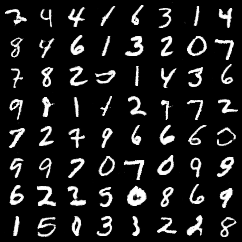

Epoch: 51  | 所要時間 0 分 8 秒
	Loss: 0.4172(Discriminator)
	Loss: 2.9412(Generator)


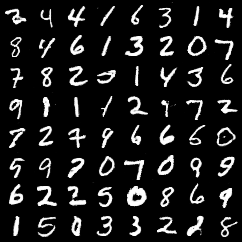

Epoch: 52  | 所要時間 0 分 8 秒
	Loss: 0.4066(Discriminator)
	Loss: 2.9655(Generator)


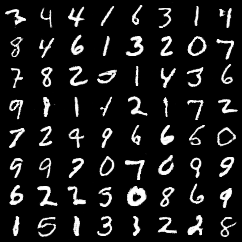

Epoch: 53  | 所要時間 0 分 8 秒
	Loss: 0.4149(Discriminator)
	Loss: 2.9626(Generator)


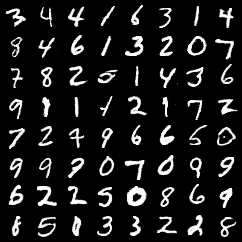

Epoch: 54  | 所要時間 0 分 8 秒
	Loss: 0.3968(Discriminator)
	Loss: 3.0061(Generator)


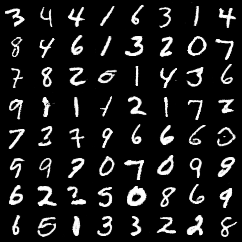

Epoch: 55  | 所要時間 0 分 8 秒
	Loss: 0.3989(Discriminator)
	Loss: 3.0308(Generator)


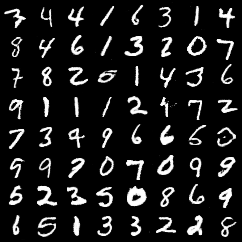

Epoch: 56  | 所要時間 0 分 8 秒
	Loss: 0.3872(Discriminator)
	Loss: 3.0548(Generator)


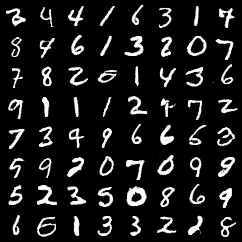

Epoch: 57  | 所要時間 0 分 8 秒
	Loss: 0.3934(Discriminator)
	Loss: 3.0754(Generator)


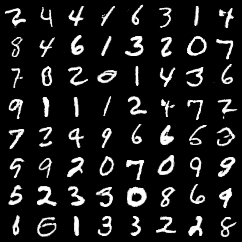

Epoch: 58  | 所要時間 0 分 8 秒
	Loss: 0.3807(Discriminator)
	Loss: 3.1168(Generator)


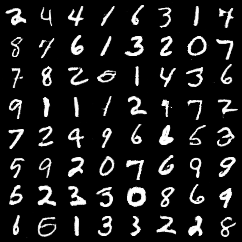

Epoch: 59  | 所要時間 0 分 8 秒
	Loss: 0.4020(Discriminator)
	Loss: 3.1006(Generator)


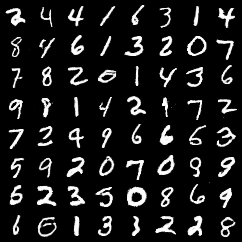

Epoch: 60  | 所要時間 0 分 8 秒
	Loss: 0.3722(Discriminator)
	Loss: 3.1494(Generator)


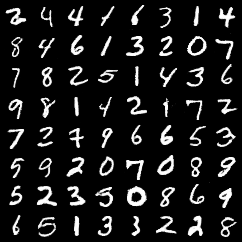

Epoch: 61  | 所要時間 0 分 8 秒
	Loss: 0.3642(Discriminator)
	Loss: 3.1782(Generator)


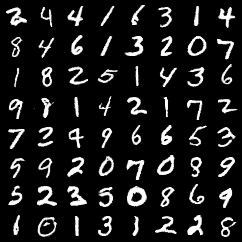

Epoch: 62  | 所要時間 0 分 8 秒
	Loss: 0.3843(Discriminator)
	Loss: 3.1697(Generator)


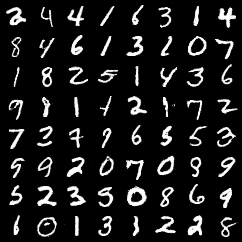

Epoch: 63  | 所要時間 0 分 8 秒
	Loss: 0.3635(Discriminator)
	Loss: 3.2178(Generator)


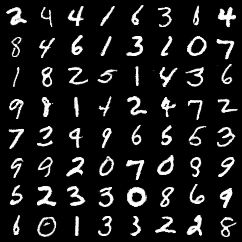

Epoch: 64  | 所要時間 0 分 8 秒
	Loss: 0.3723(Discriminator)
	Loss: 3.2584(Generator)


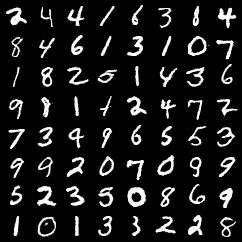

Epoch: 65  | 所要時間 0 分 8 秒
	Loss: 0.3715(Discriminator)
	Loss: 3.2356(Generator)


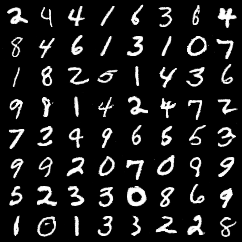

Epoch: 66  | 所要時間 0 分 8 秒
	Loss: 0.3589(Discriminator)
	Loss: 3.2570(Generator)


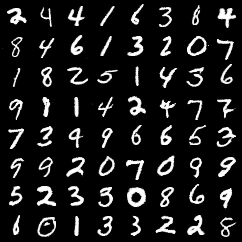

Epoch: 67  | 所要時間 0 分 8 秒
	Loss: 0.3693(Discriminator)
	Loss: 3.2566(Generator)


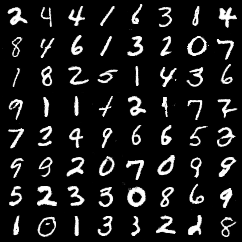

Epoch: 68  | 所要時間 0 分 8 秒
	Loss: 0.3506(Discriminator)
	Loss: 3.3011(Generator)


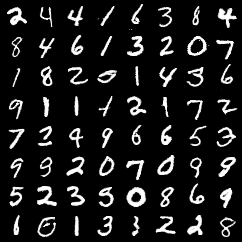

Epoch: 69  | 所要時間 0 分 8 秒
	Loss: 0.3442(Discriminator)
	Loss: 3.3505(Generator)


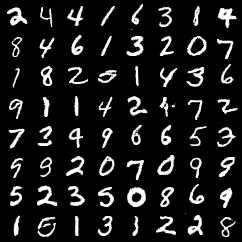

Epoch: 70  | 所要時間 0 分 8 秒
	Loss: 0.3762(Discriminator)
	Loss: 3.3062(Generator)


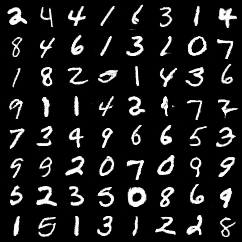

Epoch: 71  | 所要時間 0 分 8 秒
	Loss: 0.3340(Discriminator)
	Loss: 3.3822(Generator)


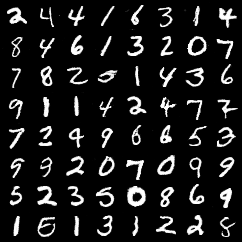

Epoch: 72  | 所要時間 0 分 8 秒
	Loss: 0.3356(Discriminator)
	Loss: 3.3946(Generator)


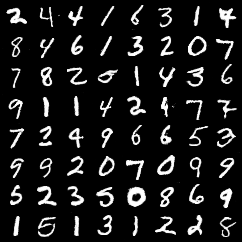

Epoch: 73  | 所要時間 0 分 8 秒
	Loss: 0.3381(Discriminator)
	Loss: 3.4056(Generator)


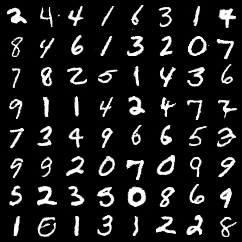

Epoch: 74  | 所要時間 0 分 8 秒
	Loss: 0.3575(Discriminator)
	Loss: 3.4318(Generator)


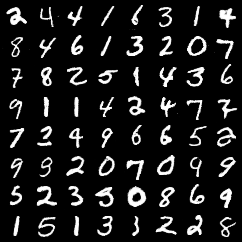

Epoch: 75  | 所要時間 0 分 8 秒
	Loss: 0.3302(Discriminator)
	Loss: 3.4320(Generator)


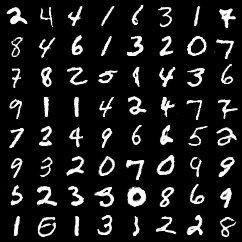

Epoch: 76  | 所要時間 0 分 8 秒
	Loss: 0.3425(Discriminator)
	Loss: 3.4720(Generator)


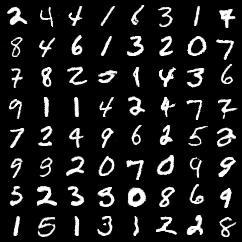

Epoch: 77  | 所要時間 0 分 8 秒
	Loss: 0.3333(Discriminator)
	Loss: 3.4627(Generator)


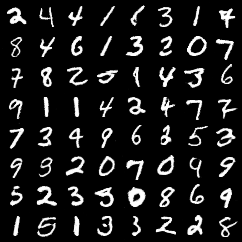

Epoch: 78  | 所要時間 0 分 8 秒
	Loss: 0.3295(Discriminator)
	Loss: 3.4887(Generator)


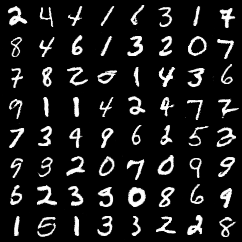

Epoch: 79  | 所要時間 0 分 8 秒
	Loss: 0.3352(Discriminator)
	Loss: 3.5253(Generator)


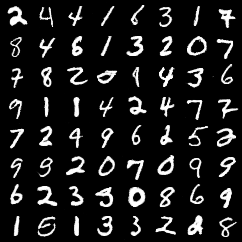

Epoch: 80  | 所要時間 0 分 8 秒
	Loss: 0.3188(Discriminator)
	Loss: 3.5334(Generator)


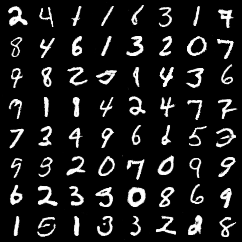

Epoch: 81  | 所要時間 0 分 8 秒
	Loss: 0.3261(Discriminator)
	Loss: 3.5405(Generator)


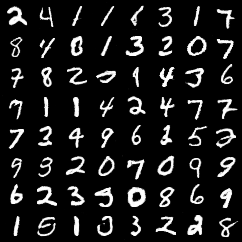

Epoch: 82  | 所要時間 0 分 8 秒
	Loss: 0.3203(Discriminator)
	Loss: 3.5710(Generator)


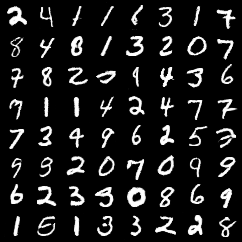

Epoch: 83  | 所要時間 0 分 8 秒
	Loss: 0.3247(Discriminator)
	Loss: 3.5850(Generator)


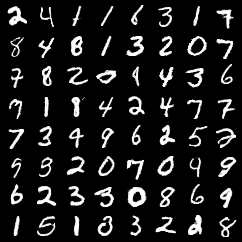

Epoch: 84  | 所要時間 0 分 8 秒
	Loss: 0.3187(Discriminator)
	Loss: 3.6100(Generator)


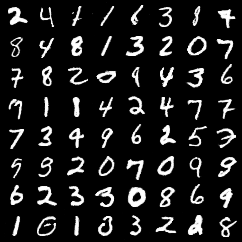

Epoch: 85  | 所要時間 0 分 8 秒
	Loss: 0.3136(Discriminator)
	Loss: 3.6305(Generator)


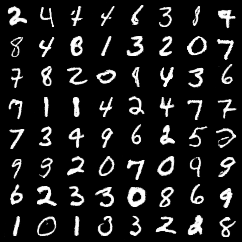

Epoch: 86  | 所要時間 0 分 8 秒
	Loss: 0.3230(Discriminator)
	Loss: 3.6653(Generator)


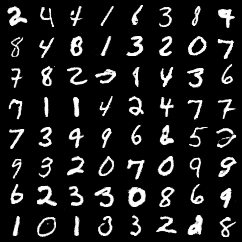

Epoch: 87  | 所要時間 0 分 8 秒
	Loss: 0.3263(Discriminator)
	Loss: 3.6234(Generator)


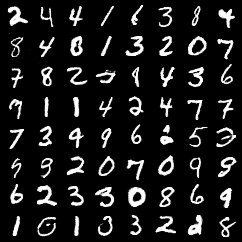

Epoch: 88  | 所要時間 0 分 8 秒
	Loss: 0.2812(Discriminator)
	Loss: 3.7285(Generator)


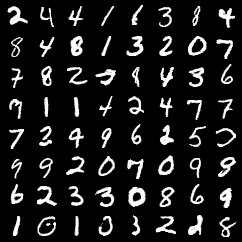

Epoch: 89  | 所要時間 0 分 8 秒
	Loss: 0.3089(Discriminator)
	Loss: 3.7333(Generator)


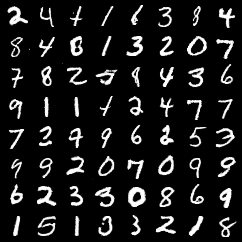

Epoch: 90  | 所要時間 0 分 8 秒
	Loss: 0.3027(Discriminator)
	Loss: 3.7004(Generator)


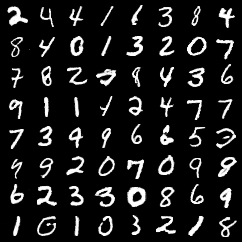

Epoch: 91  | 所要時間 0 分 8 秒
	Loss: 0.3024(Discriminator)
	Loss: 3.7345(Generator)


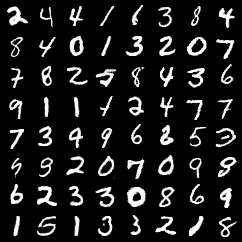

Epoch: 92  | 所要時間 0 分 8 秒
	Loss: 0.2923(Discriminator)
	Loss: 3.7769(Generator)


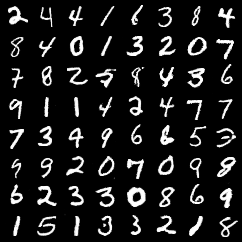

Epoch: 93  | 所要時間 0 分 8 秒
	Loss: 0.3068(Discriminator)
	Loss: 3.7864(Generator)


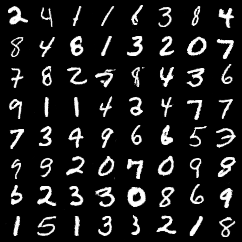

Epoch: 94  | 所要時間 0 分 8 秒
	Loss: 0.3026(Discriminator)
	Loss: 3.7666(Generator)


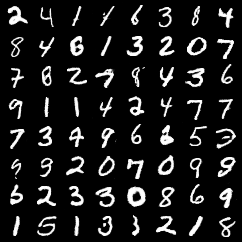

Epoch: 95  | 所要時間 0 分 8 秒
	Loss: 0.2973(Discriminator)
	Loss: 3.8250(Generator)


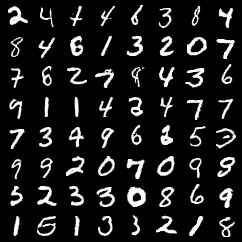

Epoch: 96  | 所要時間 0 分 8 秒
	Loss: 0.2858(Discriminator)
	Loss: 3.8347(Generator)


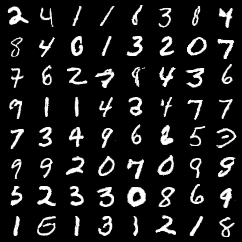

Epoch: 97  | 所要時間 0 分 8 秒
	Loss: 0.2944(Discriminator)
	Loss: 3.8602(Generator)


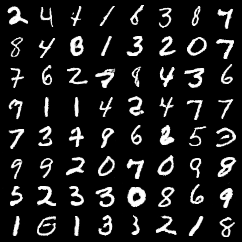

Epoch: 98  | 所要時間 0 分 8 秒
	Loss: 0.2875(Discriminator)
	Loss: 3.8562(Generator)


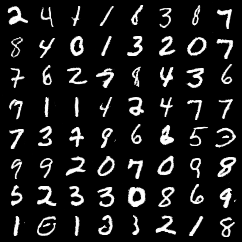

Epoch: 99  | 所要時間 0 分 8 秒
	Loss: 0.2845(Discriminator)
	Loss: 3.9048(Generator)


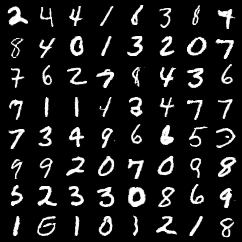

Epoch: 100  | 所要時間 0 分 8 秒
	Loss: 0.2795(Discriminator)
	Loss: 3.9099(Generator)


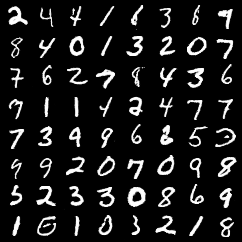

In [19]:
D_loss_list, G_loss_list = model_run(num_epochs = 100, batch_size = batch_size, D_optim = 'Adam', G_optim = 'Adam')

## グラフにGeneratorとDiscriminatorのlossを表示する関数

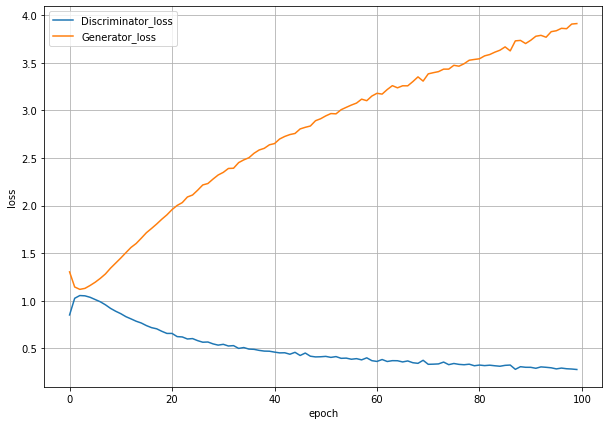

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(D_loss_list)),D_loss_list,label='Discriminator_loss')
loss.plot(range(len(G_loss_list)),G_loss_list,label='Generator_loss')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')

loss.legend()
loss.grid()

fig.show()

## アニメーションのGIFを作る

In [21]:
import glob
from PIL import Image

files = glob.glob('./logs_DCGAN/*.png')
files.sort()

images = list(map(lambda file: Image.open(file), files))

images[0].save('DCGAN.gif', save_all=True, append_images=images[1:], duration=100, loop=0)